# Setup

In [1]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [10,6]

HOME_DIR = '../..'

data = pd.read_csv(os.path.join(HOME_DIR, 'data/raw/train.csv'))

# Bird's eye view

## Outside of the actual review text, the provided information is very basic
Each row is a review.
- `ex_id` is the review ID.
- `user_id` is the user who made the review. A user can make multiple reviews
- `prod_id` is the restaurant getting reviewed. A restaurant can get multiple reviews.
- `rating` is the rating given by the user to the restaurant, on a 1-5 scale.
- `label` is whether the review was deemed real or fake.
- `date` is the date in which the user made the review.
- `review` is the text of the review itself.

In [2]:
data.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...


## Class imbalance present with fake reviews making up only around 12.5% of dataset
Please do note that this is a problem of *relative* class imbalance, where there are more of one class than another, but there are lots of examples of both classes. An *absolute* class imbalance would have very few examples of one class (e.g. if there were 50 fake reviews then it would be an absolute class imbalance).

We can do simple random undersampling or oversampling to address relative class imbalance, but in my experience I haven't seen performance differences whether we use them or not. I've noticed people really like to suggest "advanced" sampling techniques like SMOTE or ADA-SYN, but [in my opinion](https://www.reddit.com/r/MachineLearning/comments/dqjb4q/d_why_resampling_imbalanced_data_isnt_always_the/f673ck5?utm_source=share&utm_medium=web2x) they are overhyped, problematic to use, and on theoretically shaky grounds. But if you want to try those out feel free to checkout the [imblearn](https://imbalanced-learn.readthedocs.io/en/stable/) package.

In [3]:
data['label'].value_counts()

0    225055
1     25819
Name: label, dtype: int64

## Certain users write a lot more reviews than others
It's natural that these should follow a power law distribution.

I'd imagine that if one review by a user is "fake", then nearly all of that user's reviews should be fake.

Text(0, 0.5, 'Number of users')

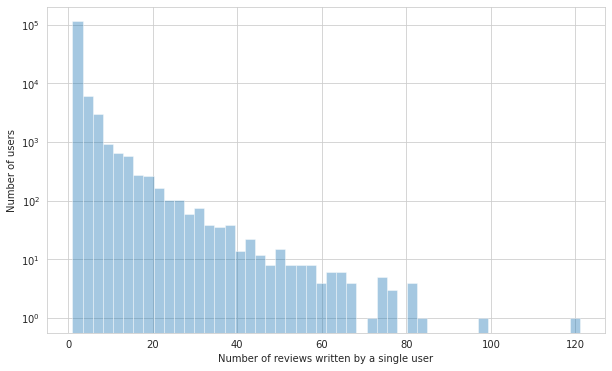

In [4]:
sns.distplot(data['user_id'].value_counts(),
             kde=False)
plt.yscale('log')
plt.xlabel('Number of reviews written by a single user')
plt.ylabel('Number of users')

The heatmap below shows that this hypothesis holds some water. The bottom row of the heatmap shows the number of users who have 0% of their reviews tagged as fake, and so have never written a fake review. The top 2 rows correspond to users who have written at least 1 spam review, with the top row corresponding to users who have written nothing but spam reviews.

We can see that if a user has written a fake review (i.e. user is in top 2 rows of heatmap), then the user is disproportionately likely to have written nothing but fake reviews (i.e. user is in top row of heatmap). 

Moreover, the majority of fake reviews are written by accounts which have written only one review total.

In [5]:
by_user = data.groupby(['user_id'])['label'].agg(['count', 'sum', 'mean'])
by_user['review_count_bin'] = pd.cut(by_user['count'], 
                                     [1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 20, 30, 50, 100, 500],
                                     right=False)
by_user['fake_pct_bin'] = np.where(by_user['mean'] == 0, '0%',
        np.where(by_user['mean'] == 1, '100%',
            '0-100%'))

crosstab = pd.crosstab(by_user['fake_pct_bin'], by_user['review_count_bin'])

Text(0.5, 1.0, 'User buckets based on their review count (x) and fake review proportions (y)')

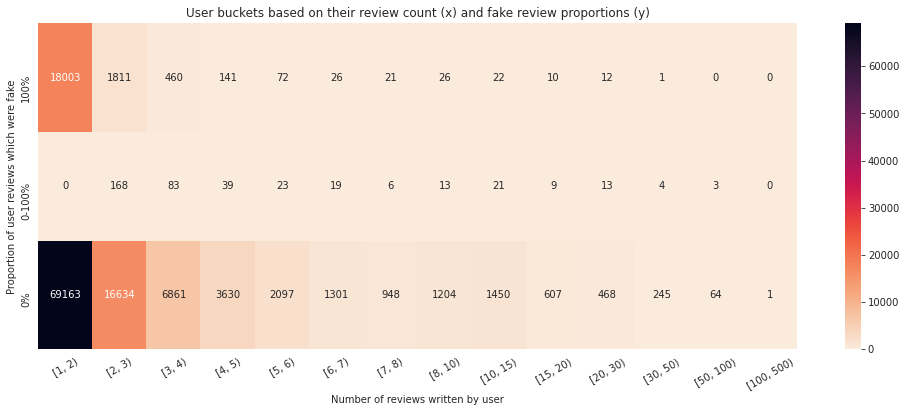

In [6]:
fig = plt.figure(figsize=(17,6))
sns.heatmap(crosstab, annot=True, 
            cmap=sns.cm.rocket_r, 
            fmt='.0f')
plt.xticks(rotation=30)
plt.gca().invert_yaxis()
plt.xlabel('Number of reviews written by user')
plt.ylabel('Proportion of user reviews which were fake')
plt.title('User buckets based on their review count (x) and fake review proportions (y)')

## Certain restaurants get a lot more reviews than others
It's also possible that certain restaurants spam their own reviews so as to boost their reputation and rankings and draw more customers.

Text(0, 0.5, 'Number of restaurants')

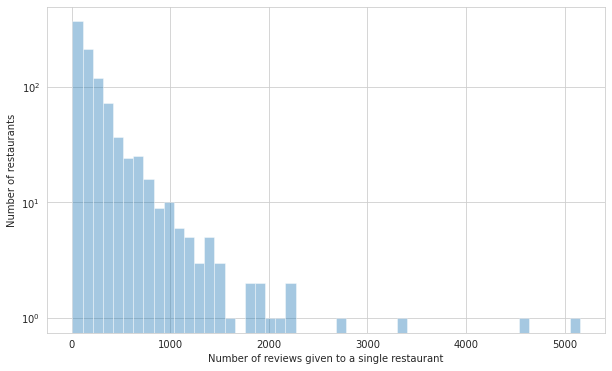

In [7]:
sns.distplot(data['prod_id'].value_counts(),
             kde=False)
plt.yscale('log')
plt.xlabel('Number of reviews given to a single restaurant')
plt.ylabel('Number of restaurants')

However, plotting the fake reviews vs. total reviews for each restaurant, we can see that nearly all restaurants have review proportions between 5% and 20%, suggesting that the above phenomenon is not as common or as severe as one might expect.

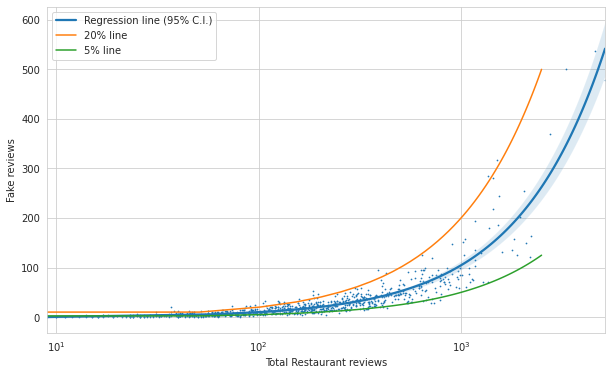

In [8]:
by_restaurant = data.groupby('prod_id')['label'].agg(['mean', 'sum', 'count'])
plt.scatter(by_restaurant['count'], 
            by_restaurant['sum'], 
            0.5)
sns.regplot(by_restaurant['count'], 
            by_restaurant['sum'], 
            scatter=False, 
            label='Regression line (95% C.I.)')
plt.plot(np.linspace(0, 2500), np.linspace(0, 500), label='20% line')
plt.plot(np.linspace(0, 2500), np.linspace(0, 125), label='5% line')
plt.xscale('log')
plt.xlabel('Total Restaurant reviews')
plt.ylabel('Fake reviews')
plt.legend()

## Ratings
In absolute terms, most ratings are 4 or 5 stars. But in relative terms, spam reviews are more likely to be low-starred than legitimate reviews.

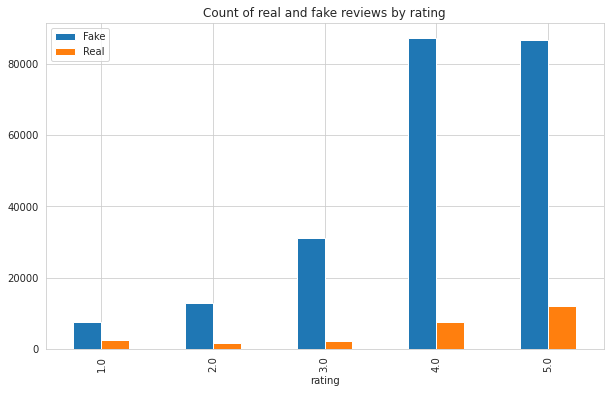

In [9]:
tmp = data.groupby(['label', 'rating'])\
    .size()\
    .reset_index()\
    .pivot_table(index='rating', columns='label')
tmp.columns = ['Fake', 'Real']
tmp.plot.bar(title='Count of real and fake reviews by rating')

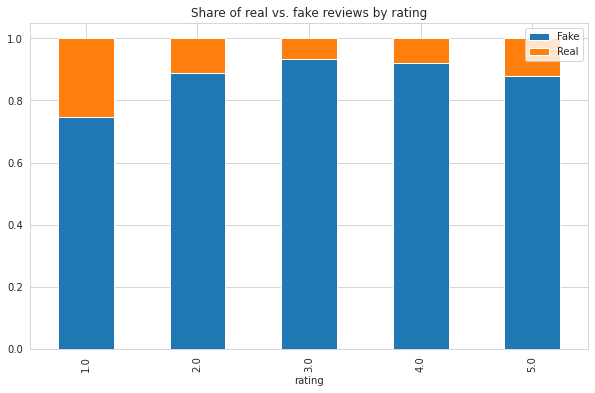

In [10]:
tmp.divide(tmp.sum(axis=1), axis=0)\
    .plot.bar(stacked=True, title='Share of real vs. fake reviews by rating')

## Review count trends upwards over the course of 10 years
Fake reviews as a proportion of total reviews appears to hold steady over the entire period.

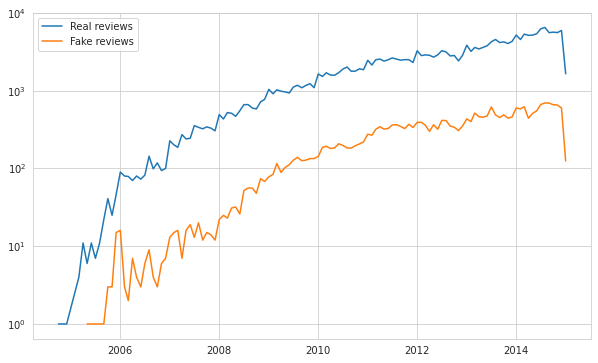

In [11]:
real_by_month = data\
    [data['label'] == 0]\
    ['date']\
    .astype('datetime64[M]')\
    .value_counts()\
    .sort_index()
fake_by_month = data\
    [data['label'] == 1]\
    ['date']\
    .astype('datetime64[M]')\
    .value_counts()\
    .sort_index()

plt.plot(real_by_month, label='Real reviews')
plt.plot(fake_by_month, label='Fake reviews')
plt.legend()
plt.yscale('log')

# Drilldown into specific reviews
We complement the birds eye view analysis with a deep dive into specific examples of real and fake reviews.

You can just rerun the functions to look at more examples.

In [12]:
def print_reviews(df):
    for i in range(len(df)):
        print('ex_id {}, prod_id {}, user_id {}, date {}, rating {}, label {}'\
            .format(df.iloc[i]['ex_id'],
                    df.iloc[i]['prod_id'],
                    df.iloc[i]['user_id'],
                    df.iloc[i]['date'],
                    df.iloc[i]['rating'],
                    df.iloc[i]['label']))
        print(df.iloc[i]['review'])
        print('\n')

## Legitimate reviews

In [13]:
real_sample = data[data['label'] == 0].sample(5)
print_reviews(real_sample)

ex_id 342218, prod_id 503, user_id 82422, date 2014-08-28, rating 5.0, label 0
Delicious Italian restaurant off the beaten path. Owners are young and passionate. As the only lunch customers on a late weekday, we were treated with samplings of wine when unsure of what to order, information on dishes from the waiter (who is also the cook), and recommendations. We all got a personal pizza, I ordered anchovy and olives, so delicious and fresh. Even got a few desserts which were equally as fresh. If you are in little Italy and don't want basic spaghetti and meatballs, try here for authentic and fresh real Italian food


ex_id 348160, prod_id 247, user_id 135243, date 2014-02-10, rating 5.0, label 0
This is the best ramen in the city and it isn't really that close.  I usually go with the hakata classic with some spciy paste and maybe a poached egg.  Really flavorful broth but not so rich that you feel disgusting for finishing it.  Crowds can be a little out of control but here's a pro tip: w

## Fake reviews

In [14]:
fake_sample = data[data['label'] == 1].sample(5)
print_reviews(fake_sample)

ex_id 201016, prod_id 542, user_id 98381, date 2014-04-14, rating 5.0, label 1
Amazing. But, everyone knows this already.


ex_id 280780, prod_id 736, user_id 136893, date 2012-07-26, rating 5.0, label 1
I was first introduced to the food, vision, and passionate team behind Maharlika through a class they taught at WholeFoods, so when a Filipino friend and I ate there a few weeks later I had high expectations .  I'm happy to report those expectations were not disappointed and, in fact, exceeded!   It was obvious that great thought, passion, and heart was poured into each dish,  translating into a unique, memorable, and most importantly, a delicious dining experience.  We walked away totally stuffed but definitely smiling!         We began with their award-winning cocktail, Pacquiao's punch (so refreshing for a hot day with a kick from fresh ginger) and a small plate of fried chicken skin (a crunchy, salty treat, similar to chicharrones).  For apps, we tucked into Arroz Caldo, infused wi

# Qualitative analysis from the info thus far

## Motivations for writing a fake review (`ex_id`s)

#### A competitor or disgruntled customer wants to disparage a restaurant and tells lies or makes vacuous claims (`ex_id=314691`)

In [15]:
tmp = data\
    [data['ex_id'].isin([314691])]
print_reviews(tmp)

ex_id 314691, prod_id 833, user_id 147715, date 2013-08-22, rating 1.0, label 1
Wow! Its a shame that if I could, I would give this place 0 Stars after my last experience here. Let me begin by stating, I LOVED Verlaines, LOVED it! Past tense. Within the last 3 months, I had probably been there about 8 times and each time, I brought a new friend to experience it with and EACH time, the said friend enjoyed it just as much as me! The same way I fell in love with the ambiance, the drinks and the food, so did they. It also goes without saying that every-time I visited, not only did myself and my guests order multiple drinks and platters, but we were ALWAYS generous with tips. This past Saturday I visited Verlaines with yet another new patron (and friend). Friend and I entered the restaurant at about 8pm, as expected, the place was packed but there was at least 1 open table available in the back. This table did not have any reservation sign, nor was there any indication it was being held. It

#### The *restaurant* wants to boost its reputation and rankings and floods itself with positive reviews (`prod_id=571`)

In [16]:
reviews_prodid = [571]
tmp = data\
    [data['prod_id'].isin(reviews_prodid) & (data['label'] == 1)]\
    .head(10)
print_reviews(tmp)

ex_id 218465, prod_id 571, user_id 22672, date 2014-11-16, rating 4.0, label 1
Solid spot.  Good grilled cheese, tater tots, mac n cheese, etc.  prices are a bit steep for a grilled cheese sandwich in my opinion but it's really close and totally decent.  Worth trying.


ex_id 218466, prod_id 571, user_id 115164, date 2014-09-26, rating 4.0, label 1
Its incredible first time i tasted i was introduce to a new level of steaks.


ex_id 218469, prod_id 571, user_id 41771, date 2014-08-05, rating 4.0, label 1
Two glasses of wine, two appetizers, a bowl of soup, two sandwiches and a slice of cake for $55 - what a great deal. Enjoyed the food immensely and would recommend for parties of 2-6!


ex_id 218470, prod_id 571, user_id 93028, date 2014-05-31, rating 4.0, label 1
i love this spot,good food. but very small


ex_id 218471, prod_id 571, user_id 115167, date 2014-05-28, rating 4.0, label 1
Great spot! A must try.


ex_id 218472, prod_id 571, user_id 115168, date 2014-10-24, rating 5.0, lab

#### The review is just irrelevant or incoherent (`ex_id=200999,261577`)

In [17]:
reviews_exid = [200999,261577]
tmp = data\
    [data['ex_id'].isin(reviews_exid)]
print_reviews(tmp)

ex_id 200999, prod_id 542, user_id 107574, date 2014-06-11, rating 5.0, label 1
taste


ex_id 261577, prod_id 673, user_id 22682, date 2014-11-26, rating 5.0, label 1
People who eat here have reported having spiritual revelations regarding their purpose on Earth, the true nature of the universe as well as deep insight into how to be the best person they possibly can. This is viewed by many as a spiritual awakening and what is often described as a rebirth. In addition, it is often reported that individuals feel they gain access to higher spiritual dimensions and make contact with various spiritual or extra-dimensional beings who can act as guides or healers,  take your order,  or just crack open the coldest Budweiser this side of Wyckoff..  I'd take a star off because of some mega babe model waitress that refused to swaddle me into a papoose and have me sleep off the rest of my meal strapped to her back, but I ALSO refuse to be defeated, and will be back.




## Signs of a fake review
- Fake reviews appear to be much shorter and more "low-effort" than real reviews (`ex_id 303077, 263612, 8816`)
- Real reviews have more "natural" sounding language; might talk about how they discovered the restaurant or how the dining experience with their boyfriend was or whatever (`ex_id 86438`)

But to be honest, there are plenty of "fake" reviews which I would not have expected to be flagged as fake.

In [18]:
reviews_exid = [303077, 263612, 8816, 86438]
tmp = data\
    [data['ex_id'].isin(reviews_exid)]
print_reviews(tmp)

ex_id 8816, prod_id 32, user_id 8980, date 2013-03-24, rating 4.0, label 1
magnificent!!!


ex_id 86438, prod_id 250, user_id 15172, date 2014-04-21, rating 4.0, label 0
Came here for a birthday dinner for my boyfriend (also our monthly "treat yo'self" dinner). They are no longer BYOB, which seemed to be a major draw, as evidenced by the reviews. Their wine list is decent. My boyfriend and I shared the goat cheese tart, which was highly reviewed, and I opted for the filet mignon with foie gras while my boyfriend had the pork tenderloin. I enjoyed the goat cheese tart, which game out in a bigger portion that I expected. My bf, unfortunately, is not a huge fan of goat cheese, so I ended up eating it all myself. Maybe not so unfortunate after all! I do like the idea that the main entrees come out with a side of vegetable purees, and I enjoyed the veggies a lot. Unfortunately, we were both a little disappointed when our food did come out, as the portions did seem a bit on the small side. H

# Baseline model with a preliminary feature set
Let's try to establish a baseline model which doesn't rely heavily on the review data, since text data requires some fairly heavy data processing.

- User review count
- Restaurant review count
- Days since first user review
- Days since first restaurant review
- Review word count
- Review letter count
- Review capitalization count
- Review punctuation count
- Review rating (provided in base dataset)

To avoid leakage, we have to do the *historical* review counts.

In [19]:
data['user_review_count'] = data\
    .sort_values(['user_id','date'])\
    .groupby('user_id')\
    ['ex_id']\
    .cumcount()
data['user_average_rating'] = data\
    .sort_values(['user_id', 'date'])\
    .groupby('user_id')\
    ['rating']\
    .cumsum() \
    / (data['user_review_count'] + 1)
data['restaurant_review_count'] = data\
    .sort_values(['prod_id', 'date'])\
    .groupby('prod_id')\
    ['ex_id']\
    .cumcount()
# not actually word count but whatever
data['wordcount'] = data['review'].str.count(" ")
first_user_review = data.groupby('user_id')['date'].min()
data['days_since_first_user'] = (pd.to_datetime(data.set_index('user_id')['date']) \
                                 - pd.to_datetime(first_user_review))\
    .dt.days\
    .reset_index(drop=True)
first_restaurant_review = data.groupby('prod_id')['date'].min()
data['days_since_first_restaurant'] = (pd.to_datetime(data.set_index('prod_id')['date']) \
                                 - pd.to_datetime(first_restaurant_review))\
    .dt.days\
    .reset_index(drop=True)
data['punctuation_count'] = data['review'].str.count('[,;:!.]')
data['capitalization_count'] = data['review'].str.count('[A-Z]+')
data['letter_count'] = data['review'].str.len()

In [20]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [21]:
train_features = ['rating', 'user_review_count', 'user_average_rating', 'restaurant_review_count',
                  'punctuation_count', 'wordcount', 'capitalization_count', 'letter_count',
                  'days_since_first_user', 'days_since_first_restaurant']

In [22]:
X = data[train_features]\
    [:230000]
y = data['label'][:230000]
tree = XGBClassifier()
tree.fit(X, y)
lr = LogisticRegression()
lr.fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
X_val = data[train_features]\
    [230000:]
y_val = data['label'][230000:]

In [24]:
y_val.value_counts()

0    18797
1     2077
Name: label, dtype: int64

In [25]:
data['pred_tree'] = tree.predict_proba(data[train_features])[:,1]
data['pred_lr'] = lr.predict_proba(data[train_features])[:,1]

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr(pred, y, label, title=None):
    precision, recall, _ = precision_recall_curve(y, pred)
    aps = average_precision_score(y_true=y, y_score=pred)
    
    plt.step(recall, precision, alpha=0.2,
             where='post',
             label='{}: Average Precision = {:0.3f}'.format(label, aps))
    plt.fill_between(recall, precision, step='post', alpha=0.2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    if title is None:
        title = 'Precision-Recall Curve'
    plt.title(title)
    plt.legend(loc="lower right")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

### Train set performance

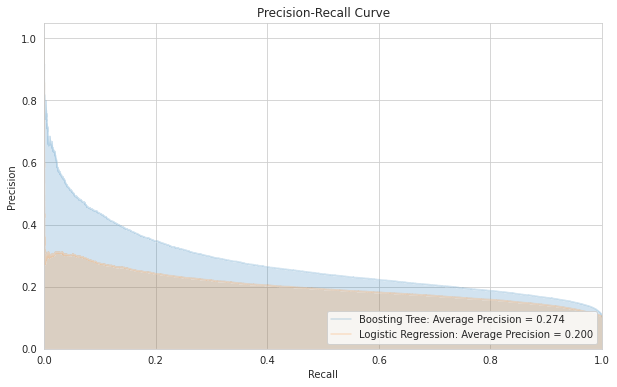

In [27]:
train = data[:230000]
plot_pr(train['pred_tree'], train['label'], label='Boosting Tree')
plot_pr(train['pred_lr'], train['label'], label='Logistic Regression')

### Validation set performance

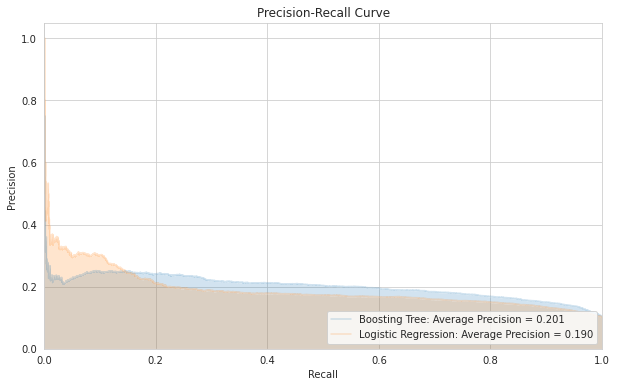

In [28]:
val = data[230000:]
plot_pr(val['pred_tree'], val['label'], label='Boosting Tree')
plot_pr(val['pred_lr'], val['label'], label='Logistic Regression')

# Further directions for data mining
Certain assertions made above are difficult to verify. For example, it is nontrivial to discuss text "sentiment" or how "colloquial" the review is as there is both some subjectivity in the concepts and quantifying them requires heavy data processing. 

I'll list out the various ways to extract information from the given dataset below and then test the easily testable hypotheses.

## Sources of minable information
- Review activity of a single user
- Review activity of a single restaurant
- The actual text in the review itself (sentiment, "casualness" of prose)
- Similarity of user reviews to reviews written by other users

# Naive Bayes on text
A quick way to mine the text information is by feeding it into a Naive Bayes model, which will learn which words and tfidf word combos tend to be associated with real vs. fake reviews. 

- Massive gains seen using the Tfidf-Vectorizer over the normal CountVectorizer
- Though not shown, no particular changes in performance seen swapping `n`-grams around

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB

In [30]:
cv = CountVectorizer(binary=False,ngram_range=(1,2), max_df=.5, min_df=.001)
text_data_train = cv.fit_transform(data['review'][:230000].tolist())
text_data_test = cv.transform(data['review'][230000:].tolist())

print(text_data_train.shape)
print(text_data_test.shape)

import scipy
text_data = scipy.sparse.vstack([text_data_train, text_data_test])

(230000, 17709)
(20874, 17709)


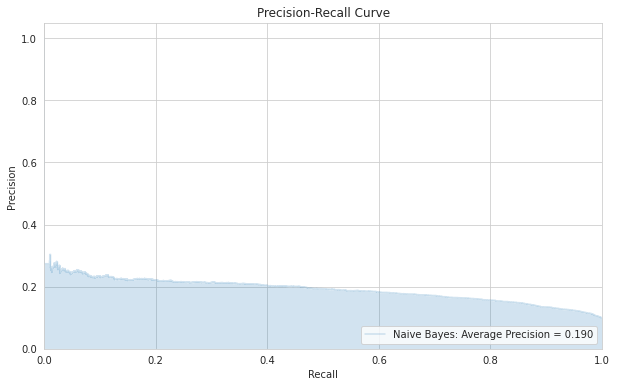

In [31]:
nb = MultinomialNB()
nb.fit(text_data_train, y)

data['pred_nb'] = nb.predict_proba(text_data)[:,1]

plot_pr(data[230000:]['pred_nb'], data[230000:]['label'], label='Naive Bayes')

## Large improvements using the `TfidfVectorizer`

In [32]:
cv = TfidfVectorizer(binary=False,ngram_range=(1,1), max_df=.5, min_df=.001)
text_data_train = cv.fit_transform(data['review'][:230000].tolist())
text_data_test = cv.transform(data['review'][230000:].tolist())

print(text_data_train.shape)
print(text_data_test.shape)

import scipy
text_data = scipy.sparse.vstack([text_data_train, text_data_test])

(230000, 4703)
(20874, 4703)


In [33]:
nb = MultinomialNB()
nb.fit(text_data_train, y)

data['pred_nb'] = nb.predict_proba(text_data)[:,1]

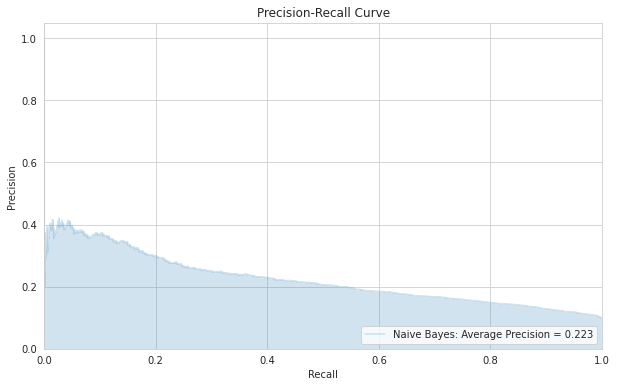

In [34]:
plot_pr(data[230000:]['pred_nb'], data[230000:]['label'], label='Naive Bayes')

## No difference using the Complement Naive Bayes
`sklearn` says the [complement naive Bayes algorithm](https://scikit-learn.org/stable/modules/naive_bayes.html) is "particularly suited for imbalanced data sets" and "regularly outperforms MNB (often by a considerable margin) on text classification tasks". 

The performance looks exactly the same.

In [35]:
nb = ComplementNB()
nb.fit(text_data_train, y)

data['pred_nb'] = nb.predict_proba(text_data)[:,1]

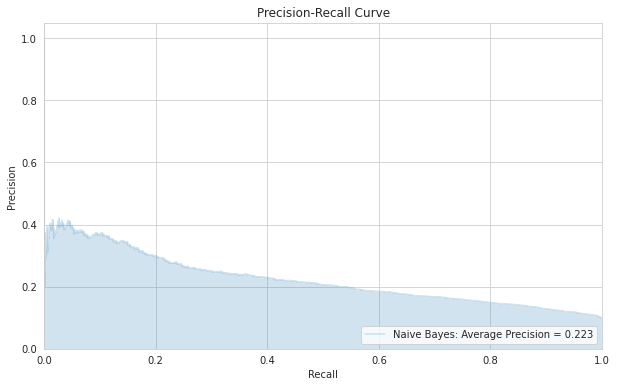

In [36]:
plot_pr(data[230000:]['pred_nb'], data[230000:]['label'], label='Naive Bayes')

## What are the largest magnitude Tfidf words for each document?
We might wonder which words see high tf-idf scores. If we leaf through the samples, we generally see that words relating to different cuisines, times, or sentiments tend to see high tf-idf scores. The lowest tfidf scores are extremely generic words. Very satisfying to observe!

In [37]:
vocab = pd.Series(cv.vocabulary_).reset_index().set_index(0)

In [38]:
def tfidf_scores(s, vocab, n=10, ascending=False):
    row_idx, col_idx, tfidf_value = scipy.sparse.find(s)
    words = vocab.loc[col_idx].copy()
    words['tfidf'] = tfidf_value
    words = words.sort_values('tfidf', ascending=ascending)[:n]
    return words['index'].tolist()

In [39]:
row_samples = np.random.randint(0, text_data.shape[0], 10)

print('Highest TFIDF')
for row in row_samples:
    print(tfidf_scores(text_data[row,:], vocab))
print('\n\n')
print('Lowest TFIDF')
for row in row_samples:
    print(tfidf_scores(text_data[row,:], vocab, ascending=True))

Highest TFIDF
['love', 'cider', 'picture', 'crepe', 'relaxed', 'hang', 'quaint', 'environment', 'banana', 'girlfriend']
['omg', 'delish', 'sucked', 'croquettes', 'plantains', 'oxtail', 'ham', 'sweet', 'good', 'food']
['dumplings', 'few', 'can', 'cashier', 'fried', 'carry', 'pork', 'additional', 'english', 'downside']
['empanada', 'empanadas', 'dessert', 'treasure', 'spicy', 'jalapenos', 'plans', 'terribly', 'fiance', '70']
['soup', 'you', 'if', 'wonton', 'dumplings', 'ridiculously', 'your', 'buns', 'right', 'not']
['dang', 'opentable', 'yorker', '30pm', 'earlier', 'so', 'phenomenal', 'needs', 'week', 'simple']
['listening', 'spin', 'dj', 'its', 'soul', 'been', 'cuban', 'lines', 've', 'afternoon']
['line', 'pizza', 'trust', 'up', 'go', 'thought', 'not', 'good', 'want', 'never']
['beer', '45pm', 'get', 'anytime', 'wednesday', 'seat', 'soon', 'wouldn', 'waited', '15']
['working', 'been', 'woorijip', 'dogs', 'strip', 'alot', 'friends', 'knowing', 'do', 'works']



Lowest TFIDF
['food', 'go

# Everything and the kitchen sink

In [40]:
everything_features = train_features + ['pred_nb']

In [41]:
tree2 = XGBClassifier()
tree2.fit(data[everything_features][:230000], y)

data['pred_everything'] = tree2.predict_proba(data[everything_features])[:,1]

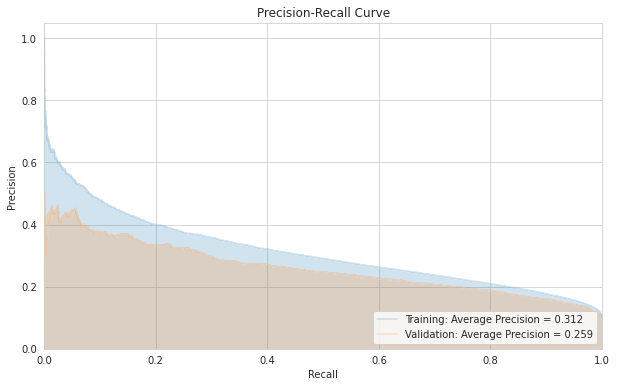

In [42]:
plot_pr(data[:230000]['pred_everything'], data[:230000]['label'], label='Training')
plot_pr(data[230000:]['pred_everything'], data[230000:]['label'], label='Validation')

# SHAP analysis
We can use SHAP values to interpret boosting trees. Here's [an article](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) describing how to read the plots.

In [43]:
import shap
shap.initjs()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


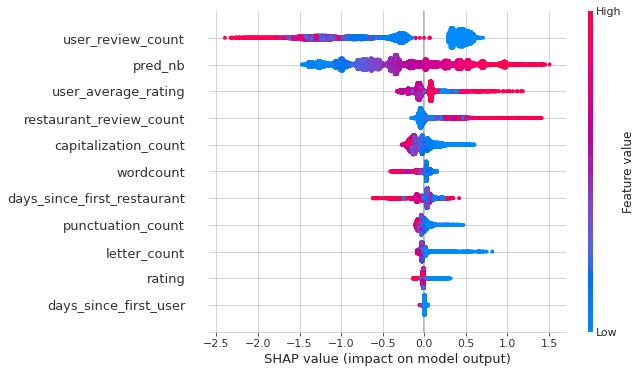

In [44]:
explainer = shap.TreeExplainer(tree2)
sv = explainer.shap_values(data[230000:][everything_features], y_val)
shap.summary_plot(sv, data[230000:][everything_features], everything_features)

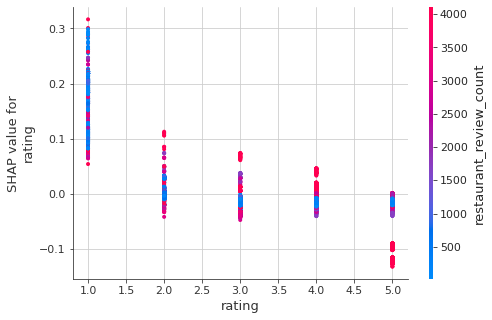

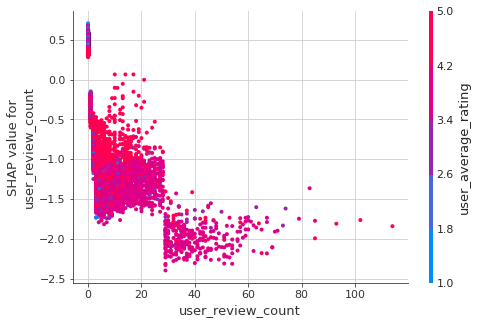

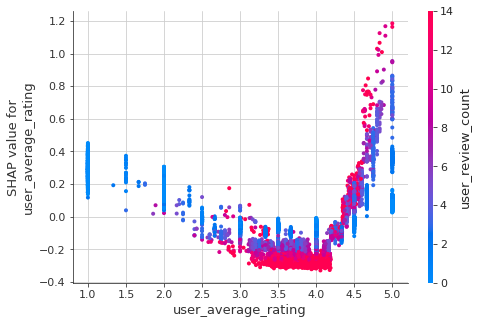

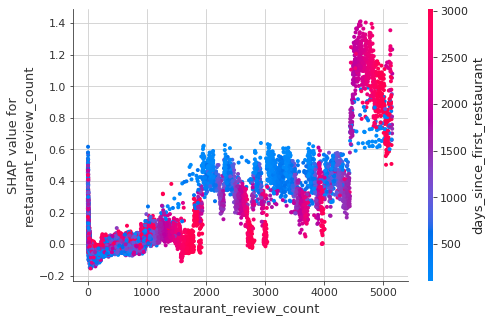

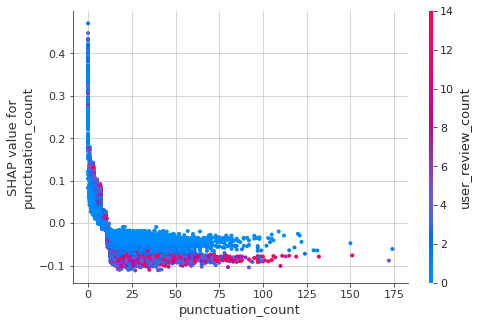

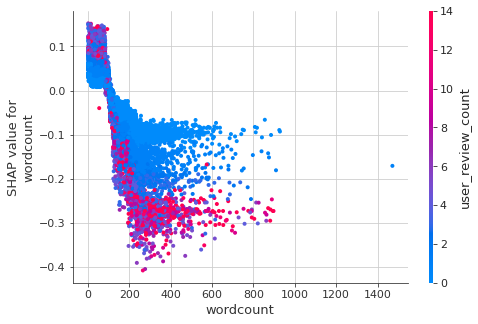

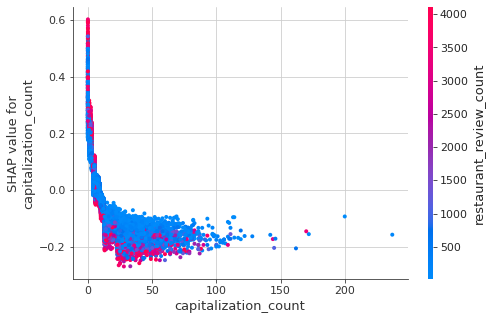

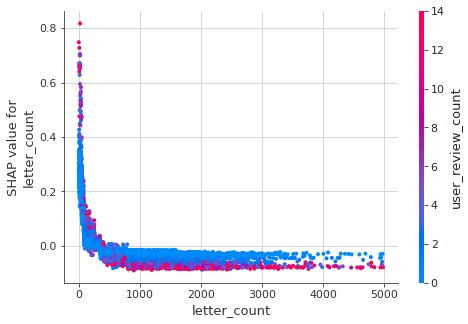

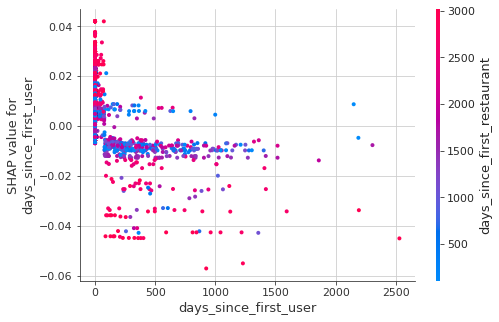

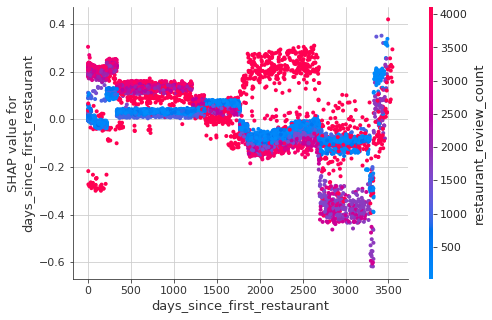

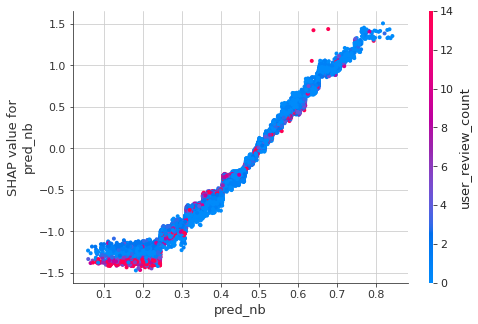

In [45]:
for feature in everything_features:
    shap.dependence_plot(feature, sv, data[230000:][everything_features], everything_features)